# Richardson's four thirds law spreading

This is a bit of code to mess with Richardson's 4/3 law spreading.

The math:

The diffusion coeff is a function of length scale:

$D = \alpha L^{4/3}$ or $L = (\frac{D}{\alpha})^\frac{3}{4}$

And the length scale (size of plume, $\sigma$) grows with the Diffusion coef:

$\frac{d \sigma^2}{dt} = 2 D  \; \; \text{or} \;\; \sigma^2 = 2 D t$

where: $\alpha$ is a constant that appears to be pretty consistent with environmental flows:

(0.002 < $\alpha$ < 0.01  $cm^{2/3}s^{-1}$ )

Once all put together, you get the variance of the "plume" growing as:

$\sigma^2 = \left({\textstyle \frac{2}{3}} \alpha t \right)^3$

or

$\sigma = \left({\textstyle \frac{2}{3}} \alpha t \right)^{3/2}$

And the diffusion coeff as a function of the variance:

$D = \frac{1}{2} \frac{d \sigma^2}{dt} = \alpha (\sigma^2)^{2/3}$

Resulting in a diffusion coeff as a function of time:

$ D = \frac{4}{9} \alpha^3 t^2 $




In [37]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [38]:
class Diffusion(object):

    alpha = 0.01 # should be between 0.002 and 0.01 all in CGS units
                 # this is the larger number -- probably suited to coastal surface flows. 
    
    def var(self, t):
        """ the variance as a function of time, according to the 4/3 law"""
        return (2.0/3.0 * self.alpha * t)**3

    def area(self, t):
        return np.pi * 4.0 * self.var(t)
        
    def sigma(self, t):
        return np.sqrt(self.var(t))
    
    def Diff(self, t):
        """The Diffusion coef as a function of time"""
        return 4.0/9.0 * self.alpha**3 * t**2
    
    def time(self, D):
        """time as a function of Diffusion coef"""
        return 3.0 * 2.0 * np.sqrt(D / self.alpha**3)
    
    def Length(self, D):
        """comutes the mixing length scale"""
        return D  / self.alpha

    

In [39]:
# what's the time and length scale of GNOME diffusion???

diff = Diffusion()
D = 1e5 # typical value for GNOME in coastal regions
#small alpha:
diff.alpha = 0.002
L = diff.Length(D)
T = diff.time(D)
print "length scale is: %f m with alpha = %f"%(L/100, diff.alpha)
print "time scale is: %f hr (%F days) with alpha = %f"%(T/3600, T/3600/24,  diff.alpha)
# or, with max alpha:
diff.alpha = 0.01
L = diff.Length(D)
T = diff.time(D)
print "length scale is: %fm with alpha = %f"%(L/100, diff.alpha)
print "time scale is: %f hr (%F days) with alpha = %f"%(T/3600, T/3600/24,  diff.alpha)


length scale is: 500000.000000 m with alpha = 0.002000
time scale is: 5892.556510 hr (245.523188 days) with alpha = 0.002000
length scale is: 100000.000000m with alpha = 0.010000
time scale is: 527.046277 hr (21.960262 days) with alpha = 0.010000


So we are looking at 100 to 500 km diffusion scale!
With time scales of 21 to 245! days

This is why the spreading scale is totally different than the diffusion scale used in transport.

## Check units!!

## Spread if we use 4/3 law...

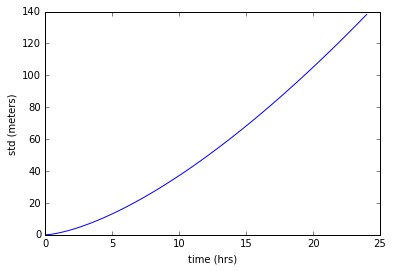

In [40]:
diff = Diffusion() # using default alpha

t = np.linspace(0, 24*3600,100) # time in seconds
std = diff.sigma(t) / 100 # std dev in meters

fig = plt.figure()  # a new figure window
ax = fig.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
ax.plot(t / 3600, std)
ax.set_xlabel("time (hrs)")
ax.set_ylabel("std (meters)")

Hmm -- kinda slow??

Say radius is 2 std... (95 of the oil)

In [41]:
area = 2 * np.pi * (2*std)**2

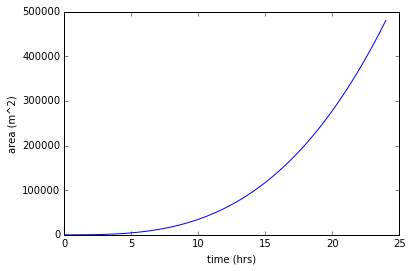

In [42]:
fig2 = plt.figure()  # a new figure window
ax = fig2.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
ax.plot(t / 3600, area)
ax.set_xlabel("time (hrs)")
ax.set_ylabel("area (m^2)")

# Computational checks...

If we compute this all as a differential equation instead -- L as a functin of time, D as a function of L, etc... we can see if the math above is right:

$D = \alpha L^{4/3}$

With fickian diffusion, $\sigma^2$ increases with D:

$ \sigma^2 = 2Dt$

In finite difference form:

$\sigma_{i+1} = \sqrt{\sigma^2_i + 2D * \delta t}$


If we substitute L for D, then we can compute the growth numerically.


## Constant Diffusion (fickian)

In [135]:
# A numerical solution to constant diffusion
from math import sqrt

D = 10 # m^2/s -- 10^5cm^2/s

time = np.linspace(0, 3600*24, 10)
time2 = np.linspace(0, 3600*24, 100)
dt = time[1] - time[0]
Sigma = np.zeros_like(time)
Sigma[0] = 0
for i in xrange(len(time)-1):
    Sigma[i+1] = sqrt( Sigma[i]**2 + 2*D*dt)


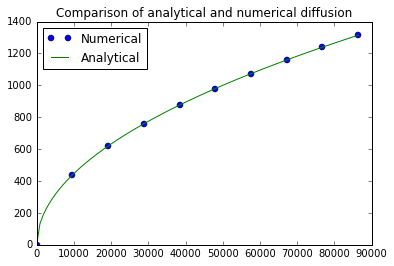

In [136]:
fig, ax = plt.subplots(1, 1)
ax.plot(time, Sigma, 'o', label='Numerical')
#analytical solution
ax.plot(time2, np.sqrt(2*D*time2), label='Analytical')
ax.legend(loc='upper left')
ax.set_title("Comparison of analytical and numerical diffusion")

## Richardson's Diffusion

This indicates that the math I did above works.

Note that the timestep has to be quite small to make the solutions match well -- at least with the Euler method. So we need to be careful there if we do this numerically.

In [159]:
# A numerical solution:
from math import sqrt
alpha = 0.01
L_0 = 1
dt = 3600
fourthirds = (4.0 / 3.0)

def DofL(L):
    # "Richardson's law"
    return alpha * L**fourthirds

time = np.linspace(0, 3600*24, 1000)
time2 = np.linspace(0, 3600*24, 10)
dt = time[1] - time[0]
Sigma = np.zeros_like(time)
Sigma[0] = L_0
for i in xrange(len(time)-1):
    Sigma[i+1] = sqrt( Sigma[i]**2 + 2*DofL(Sigma[i])*dt)


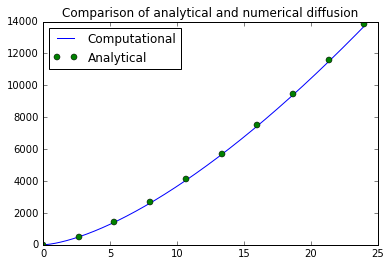

In [160]:
fig, ax = plt.subplots(1, 1)
ax.plot(time/3600, Sigma, label="Computational")
#analytical solution
ax.plot(time2/3600, (2./3.*alpha*time2)**(3./2.), 'o', label='Analytical')
ax.legend(loc='upper left')
ax.set_title("Comparison of analytical and numerical diffusion")